## Import Libraries and Data

In [7]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_06-7-03-23.csv', firstRow=132, lastRow=138)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_070323_S133-138.csv',t_baseline=25,derivNoise=0.005,secDerivNoise=0.001)

## Analyse Water Addition

In [8]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=84s and ended at t=474s; mass=44.5111g
This equals a volume of 44.6m; expected was 44.643mL; error is 0.096%


## Analyse Surfactants

Peak threshold for 1st derivative = 0.0025 g/s and for 2nd derivative = 0.000625 g/s^2


<IPython.core.display.Javascript object>


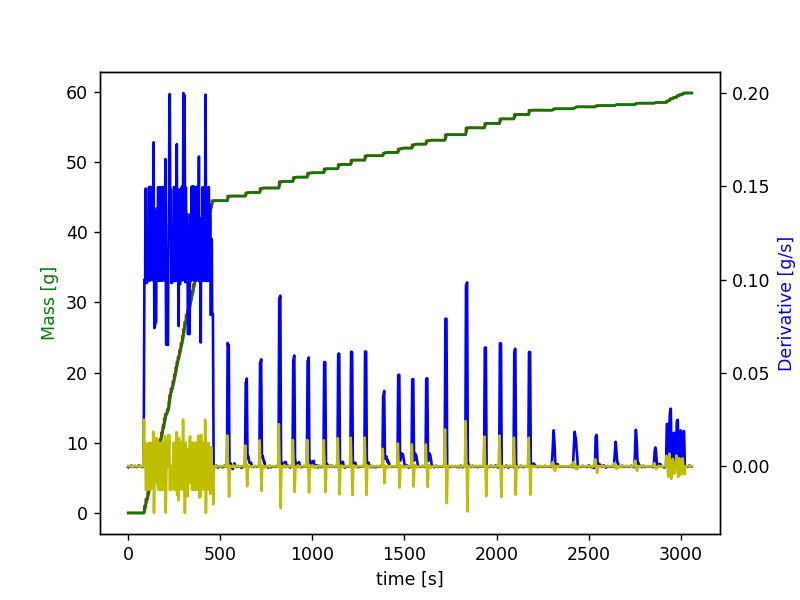

Addition of 0.659g Texapon SB 3 KC detected from 534s to 554s - expected volume = 0.994mL and actual volume = 0.597mL (resulting error is 39.918%)
Addition of 0.515g Plantacare 2000 detected from 632s to 660s - expected volume = 0.585mL and actual volume = 0.476mL (resulting error is 18.705%)
Addition of 0.63g Plantacare 2000 detected from 710s to 746s - expected volume = 0.585mL and actual volume = 0.583mL (resulting error is 0.411%)
Addition of 0.933g Dehyton MC detected from 814s to 852s - expected volume = 0.911mL and actual volume = 0.864mL (resulting error is 5.224%)
Addition of 0.604g Dehyton MC detected from 890s to 912s - expected volume = 0.535mL and actual volume = 0.563mL (resulting error is 5.174%)
Addition of 0.626g Dehyton MC detected from 968s to 1014s - expected volume = 0.535mL and actual volume = 0.583mL (resulting error is 8.99%)
Addition of 0.563g Dehyton PK 45 detected from 1058s to 1078s - expected volume = 0.559mL and actual volume = 0.539mL (resulting error is 

In [9]:
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant', steps=steps,start_idx=t1,show=True)

## Analyse Polyelectrolytes

Peak threshold for 1st derivative = 0.0025 g/s and for 2nd derivative = 0.0006250000000000001 g/s^2


<IPython.core.display.Javascript object>


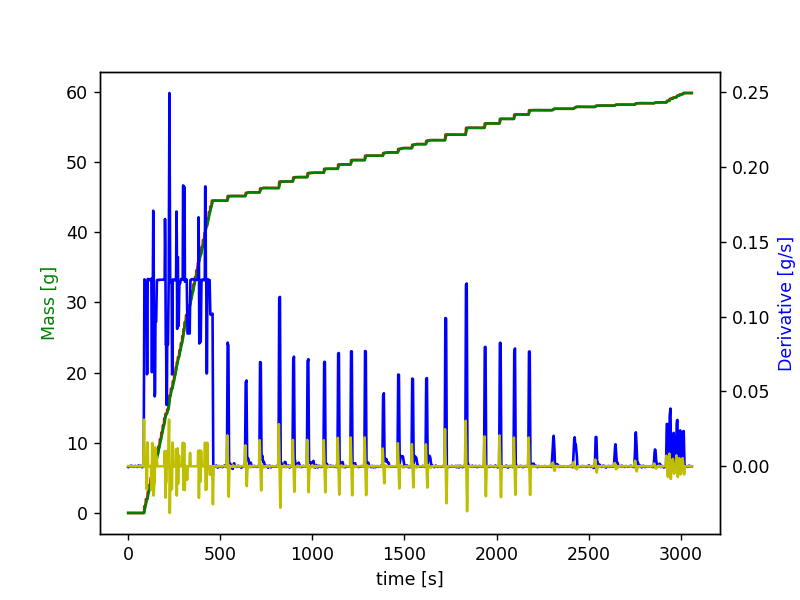

Addition of 0.205g Luviquat Excellence detected from 2298s to 2322s - expected volume = 0.207mL and actual volume = 0.187mL (resulting error is 9.923%)
Addition of 0.276g Luviquat Excellence detected from 2412s to 2442s - expected volume = 0.253mL and actual volume = 0.247mL (resulting error is 2.297%)
Addition of 0.175g Luviquat Excellence detected from 2530s to 2552s - expected volume = 0.157mL and actual volume = 0.159mL (resulting error is 1.156%)
Addition of 0.147g Luviquat Excellence detected from 2636s to 2664s - expected volume = 0.123mL and actual volume = 0.132mL (resulting error is 7.117%)
Addition of 0.208g Luviquat Excellence detected from 2746s to 2768s - expected volume = 0.187mL and actual volume = 0.189mL (resulting error is 1.341%)
Addition of 0.111g Luviquat Excellence detected from 2852s to 2874s - expected volume = 0.099mL and actual volume = 0.102mL (resulting error is 3.241%)


In [10]:
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=5, mergeSens=5, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

## Analyse Thickeners

Peak threshold for 1st derivative = 0.005 g/s and for 2nd derivative = 0.0025 g/s^2


<IPython.core.display.Javascript object>


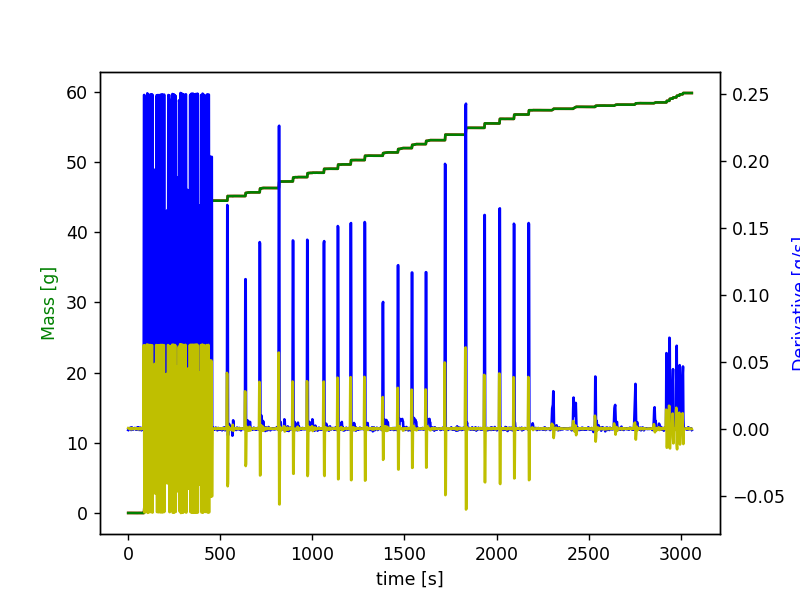

Addition of 0.227g Arlypon TT detected from 2918s to 2930s - expected volume = 0.256mL and actual volume = 0.238mL (resulting error is 6.762%)
Addition of 0.308g Arlypon TT detected from 2934s to 2948s - expected volume = 0.302mL and actual volume = 0.317mL (resulting error is 5.119%)
Addition of 0.179g Arlypon TT detected from 2952s to 2964s - expected volume = 0.143mL and actual volume = 0.186mL (resulting error is 30.292%)
Addition of 0.248g Arlypon TT detected from 2972s to 2984s - expected volume = 0.227mL and actual volume = 0.256mL (resulting error is 12.5%)
Addition of 0.192g Arlypon TT detected from 2988s to 3000s - expected volume = 0.159mL and actual volume = 0.202mL (resulting error is 27.152%)
Addition of 0.186g Arlypon TT detected from 3006s to 3018s - expected volume = 0.169mL and actual volume = 0.196mL (resulting error is 16.25%)


In [11]:
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=5, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

## Consolidate results and create output

In [12]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_070323_S133-S138.csv', index=False)
actualMassFractions

C:\Users\ACHI01\AppData\Local\Temp\ipykernel_19916\395465846.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for entry in sampleList[i].addedMassSeries.iteritems():


,ID,Texapon SB 3 KC,Plantapon ACG 50,Plantapon LC 7,Plantacare 818,Plantacare 2000,Dehyton MC,Dehyton PK 45,Dehyton ML,Dehyton AB 30,Plantapon Amino SCG-L,Plantapon Amino KG-L,Dehyquart A-CA,Luviquat Excellence,Dehyquart CC6,Dehyquart CC7 Benz,Salcare Super 7,Arlypon F,Arlypon TT
132,133.0,0.000000,0.0,0.0,0.0,0.000000,9.279265,11.563759,0.000000,0.0,0.000000,0.00000,0.000000,2.043458,0.0,0.0,0.0,0.0,2.263599
133,134.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,7.912965,0.00000,12.901616,2.768136,0.0,0.0,0.0,0.0,3.083493
134,135.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,10.953076,0.0,0.000000,9.89378,0.000000,1.755461,0.0,0.0,0.0,0.0,1.790571
135,136.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,11.231562,0.0,0.000000,0.00000,12.267300,1.454493,0.0,0.0,0.0,0.0,2.453063
136,137.0,0.000000,0.0,0.0,0.0,11.324248,0.000000,12.136231,0.000000,0.0,0.000000,0.00000,0.000000,2.054683,0.0,0.0,0.0,0.0,1.898913
137,138.0,6.677798,0.0,0.0,0.0,0.000000,12.454888,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,1.129684,0.0,0.0,0.0,0.0,1.884495
